**Кулешов Иван AML-14**

# Временные ряды, задание №2
## по теме "Элементарные методы анализа временных рядов"

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Тест Дики-Фуллера на стационарность, возвращает p_value и значение лага
def test_stationarity_pvalue(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dftest[1], dftest[2]

# Выводит график и коррелограмму
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    p_value, lag = test_stationarity_pvalue(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Решение

Для исследований возьмем, разумеется, ряд international-airline-passengers.csv как нестационарный, с выраженным изменением тренда и сезонностью.

In [4]:
df = pd.read_csv("international-airline-passengers.csv", sep=',')
series = df['Count']

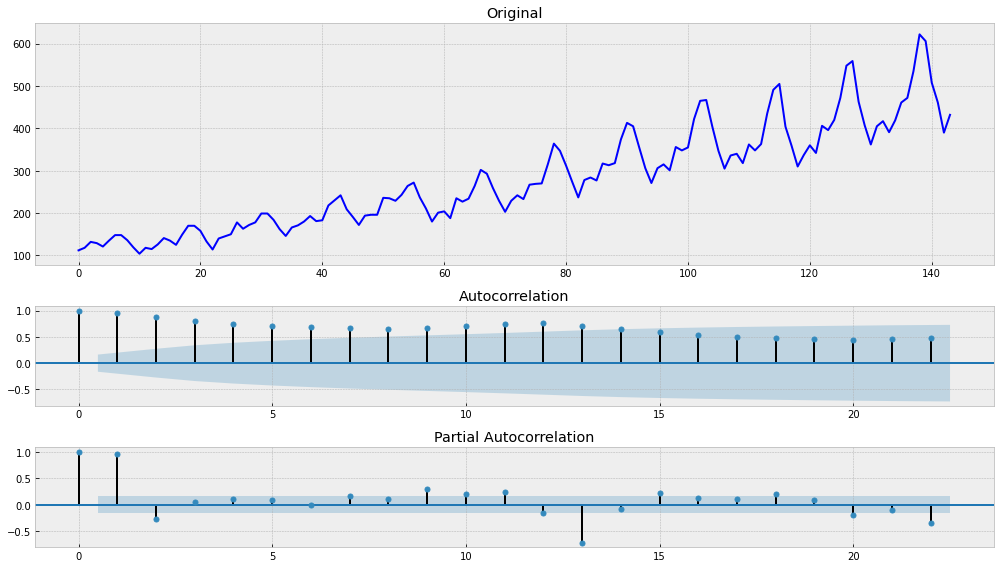

In [5]:
# Выведем оригинальный ряд.
tsplot(series)

Этот ряд не является стационарным, приведем его к стационарности: применим перобразование Бокса-Кокса, продифференцируем, уберем сезонность

In [6]:
# Убираем размах дисперсии, дифференцируем, делаем тест на стационарность, получаем размер лага
diff_series = np.diff(boxcox(series, 0), 1)
p_value,lag = test_stationarity_pvalue(diff_series)

Выведем нестационарный ряд:

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


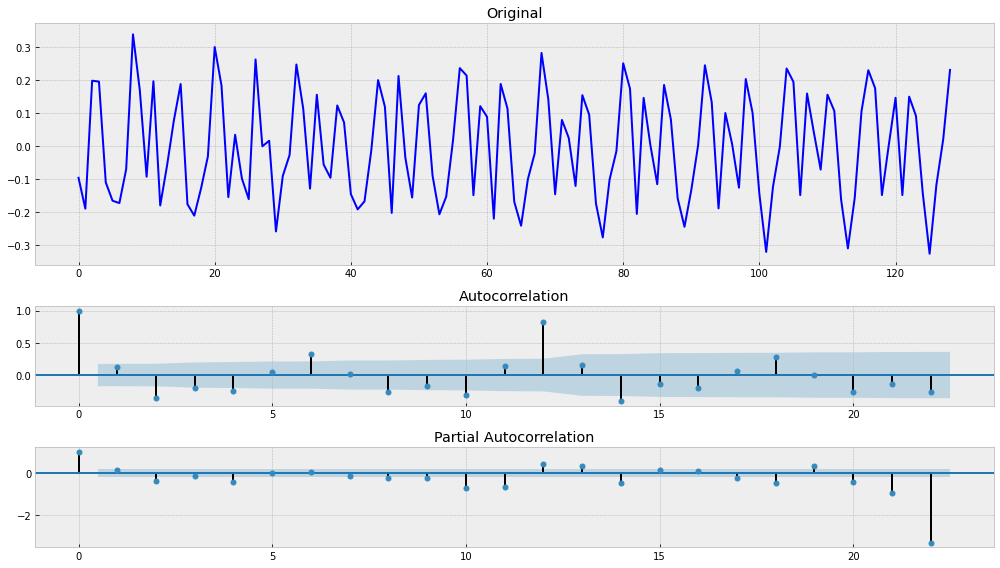

In [7]:
stat_series = diff_series[lag:] - diff_series[:-lag]
tsplot(stat_series)

Итак, у нас есть два ряда - стационарный и нестационарный, попробуем на них различные способы приближения

## Скользящее среднее

In [13]:
# Скользящее среднее для размера окна = n
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [24]:
# Отрисовка Оригинального ряда и скользящего среднего
def moving_average_test(series,windows=[5], label='original'):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='red',label=label)
        for window in windows:
            ser = moving_average(series, window)
            plt.plot(ser,  linewidth='2', label='Moving Average {}'.format(window))
        plt.legend()

Скользящее среднее на нестационарном ряде:

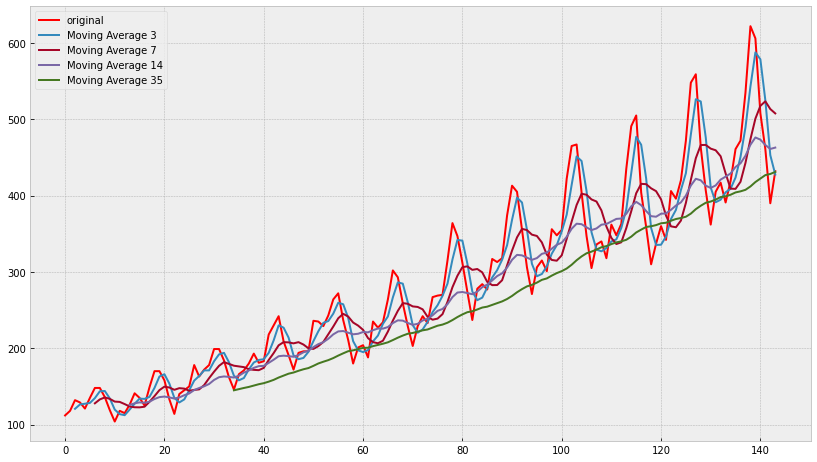

In [25]:
moving_average_test(series, windows = [3,7,14,35])

Скользящее среднее на стационарном ряде:

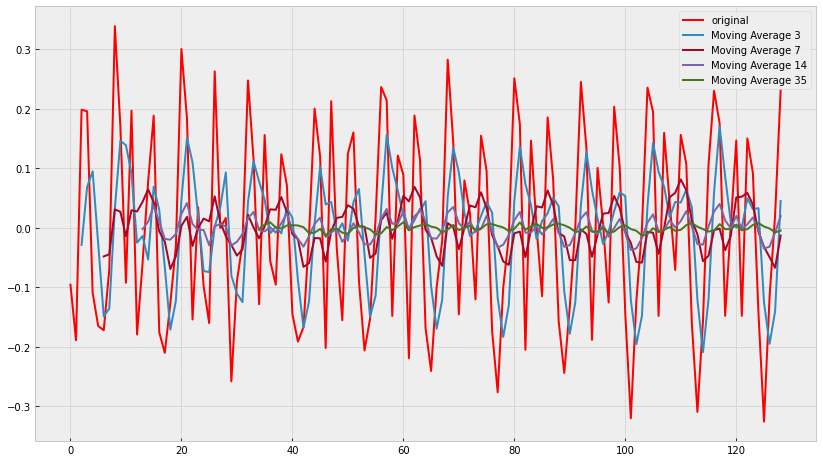

In [26]:
moving_average_test(stat_series, windows = [3,7,14,35])

**Вывод:** 

Можно отметить, что скользящее среднее не особо хорошо приближает исходный ряд. Можно отметить, что чем меньше размер окна, тем ближе к исходному ряду, а на нестационарном ряде скользящее среднее при большом размере окна приближает линию тренда этого ряда.

## Взвешенное скользящее среднее

Взвешенное среднее - это попытка дать больше влияния самым недавним значениям ряда на последующие, с каким-то взвешенным убыванием этого влияния для значений ряда из прошлого.

In [27]:
# Взвешенное скользящее среднее
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [31]:
# Отрисовка оригинального ряда и взвешенного среднего
def weighted_moving_average_test(series, weights, label='original'):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='red',label='original')
        for w_label,weigth in weigths:
          plt.plot(weighted_moving_average(series, len(weigth), weigth), linewidth='2', label=w_label)
        plt.legend()

In [ ]:
# Попробуем разные подходы к взвешиванию
weigths=[('Фиббоначи', [1,1,2,3,5,8,13]), 
         ('Последовательность', [1,2,3,4,5,6,7]), 
         ('Степени двойки', [1,2,4,8,16,32,64])]

Взвешенное скользящее среднее на нестационарном ряде:

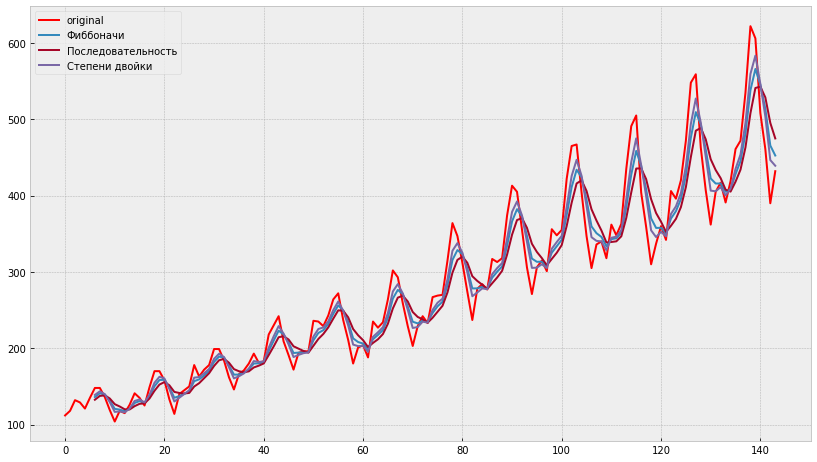

In [33]:
weighted_moving_average_test(series,weights=weigths)

Взвешенное скользящее среднее на стационарном ряде:

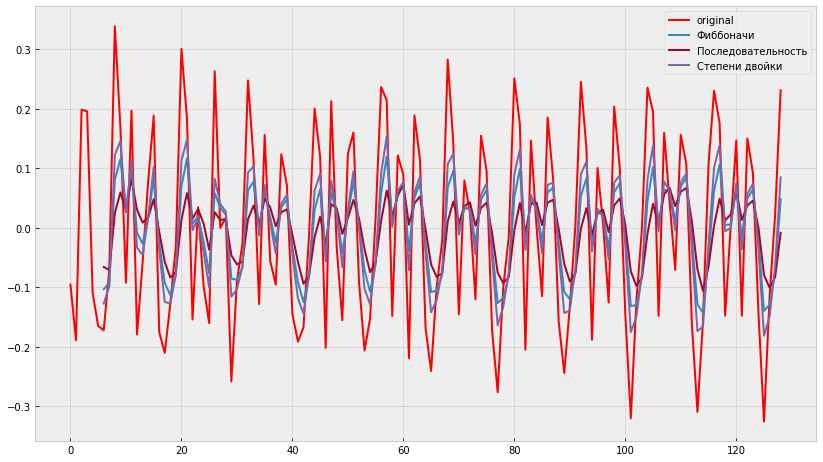

In [34]:
weighted_moving_average_test(stat_series,weights=weigths)

**Вывод:**

Взвешенное скользящее среднее дает заметно лучший результат, чем просто скользящее среднее. Наилучшими параметрами для взвешенного скользящего среднего оказались степени двойки.

## Экспоненциальное сглаживание

In [6]:
# Экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [7]:
def exponential_moving_average_test(series, alphas, label='original'):
  with plt.style.context('bmh'):
      plt.figure(figsize=(14, 8))
      plt.plot(series, color='red',label=label)
      for alpha in alphas:
          plt.plot(exponential_moving_average(series, alpha), linewidth='2', label='EMA {}'.format(alpha))
      plt.legend()

Экспоненциальное сглаживание на нестационарном ряде:

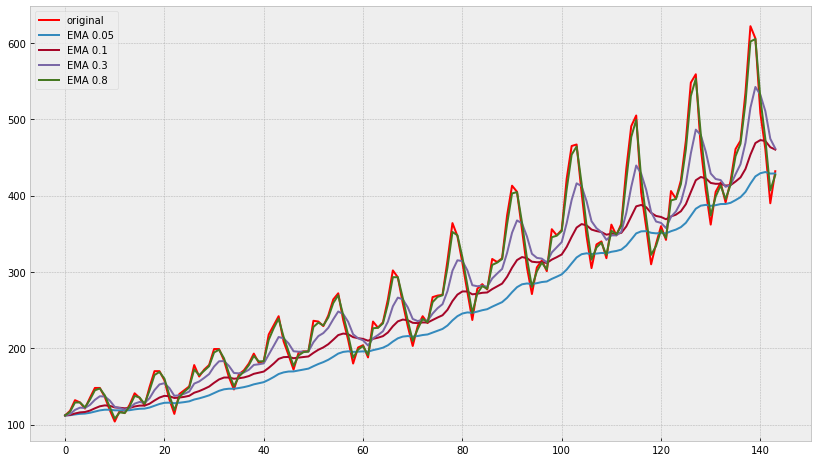

In [8]:
alphas = [0.05,0.1,0.3,0.8]
exponential_moving_average_test(series,alphas=alphas)

Экспоненциальное сглаживание на стационарном ряде:

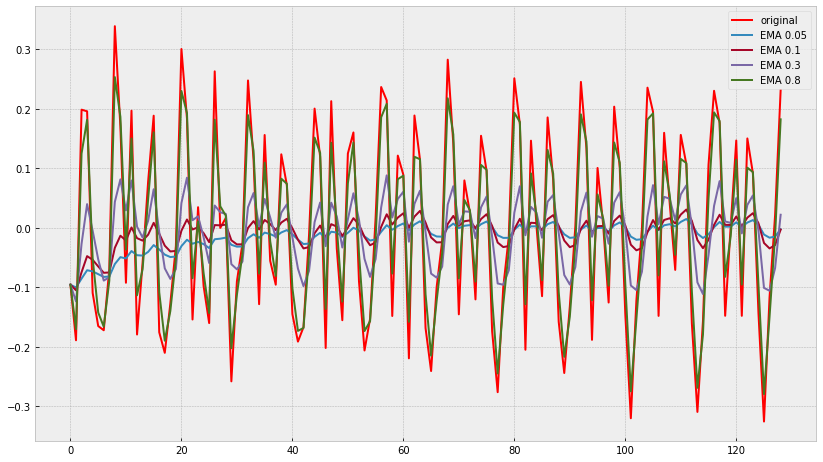

In [9]:
exponential_moving_average_test(stat_series,alphas=alphas)

**Вывод:**

При alpha, близких к 1 выдает последовательности, близкие к исходным.

## Двойное экспоненциальное сглаживание

In [14]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [23]:
def double_ema_test(series, alphas, betas, label='original'):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='red',label=label)
        for alpha,beta in zip(alphas,betas):
          plt.plot(double_ema(series, alpha, beta), linewidth='1', label='DEMA alpha={}, beta={}'.format(alpha, beta))
        plt.legend()

Двойное экспоненциальное сглаживание для нестационарного ряда:

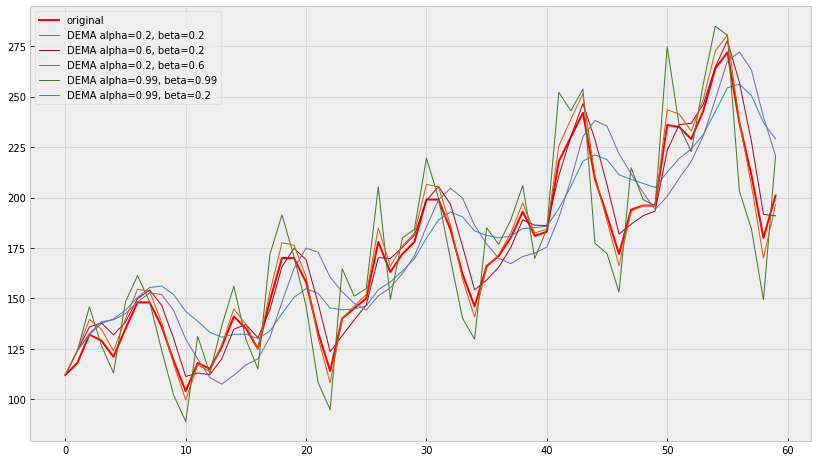

In [24]:
alphas, betas = [0.2, 0.6,0.2,0.99,0.99], [0.2, 0.2,0.6,0.99,0.2]
double_ema_test(series[:60], alphas=alphas, betas=betas)

Двойное экспоненциальное сглаживание для стационарного ряда:

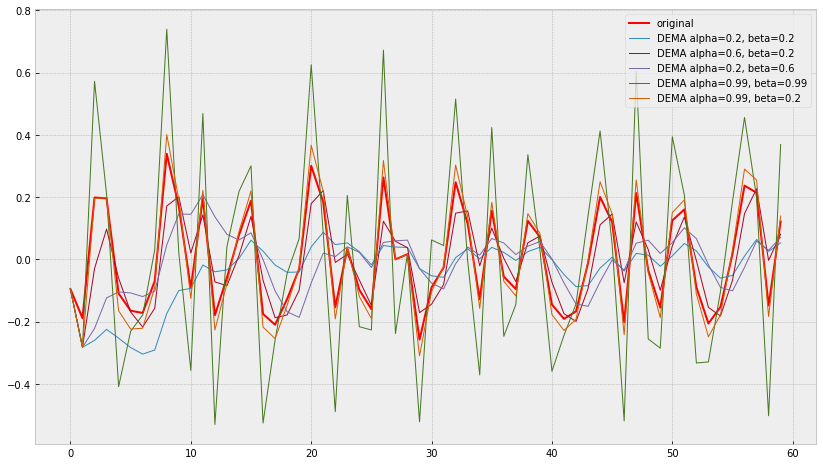

In [25]:
alphas, betas = [0.2, 0.6,0.2,0.99,0.99], [0.2, 0.2,0.6,0.99,0.2]
double_ema_test(stat_series[:60], alphas=alphas, betas=betas)

**Вывод:**

Как видно, сочетание параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

#### Подбираем параметры для рядов

In [151]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

In [152]:
# Функция для кросс-валидации, X - итерируемые параметры, train_series - временной ряд 
def dema_mse_cross_val(X, train_series):
    train_series = pd.Series(train_series)
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    
    for train_split, test_split in split.split(train_series):
        train_split_ts = train_series.iloc[train_split]
        test_split_ts = train_series.iloc[test_split]

        result = double_ema_with_preds(pd.Series(train_split_ts), alpha, beta, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

Разбиваем временной ряд на train - с помощью кросс-валидации на train будем обучать параметры; val - для сравнения исходного ряда с предсказанными значениями

In [153]:
train, val = series[:115], series[115:]

Оптимизируем параметры, передается фукнция, итерируемые параметры, остальные параметры (args), метод и размах парамеров

In [154]:
opt_dema = minimize(dema_mse_cross_val, x0=[0.0,0.0], args=train, method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [155]:
alpha_opt_dema, beta_opt_dema = opt_dema.x
opt_dema

      fun: 2569.3929339424426
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.80476148e+02,  2.31921149e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 10
   status: 0
  success: True
        x: array([1.        , 0.02159015])

In [156]:
# Функция для отрисовки исходнго ряда и расчетного
def plot_dema(alpha, beta, ser_orig, ser_preds, n_preds):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_orig, color='red',label='original')
        plt.plot(double_ema_with_preds(ser_preds, alpha, beta, n_preds), linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

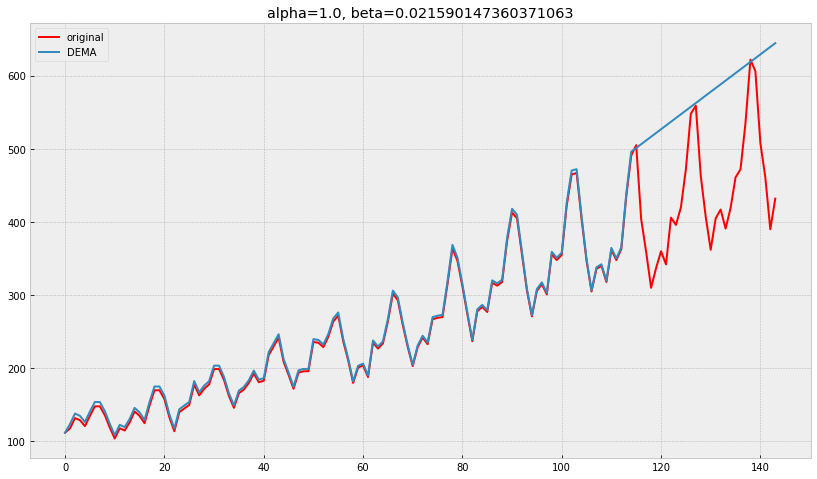

In [157]:
plot_dema(alpha_opt_dema, beta_opt_dema, series, train, len(val))

Нестационарный ряд предсказывается плохо, прогноз сразу выродился в прямую.

Посмотрим, что со стационарным рядом:

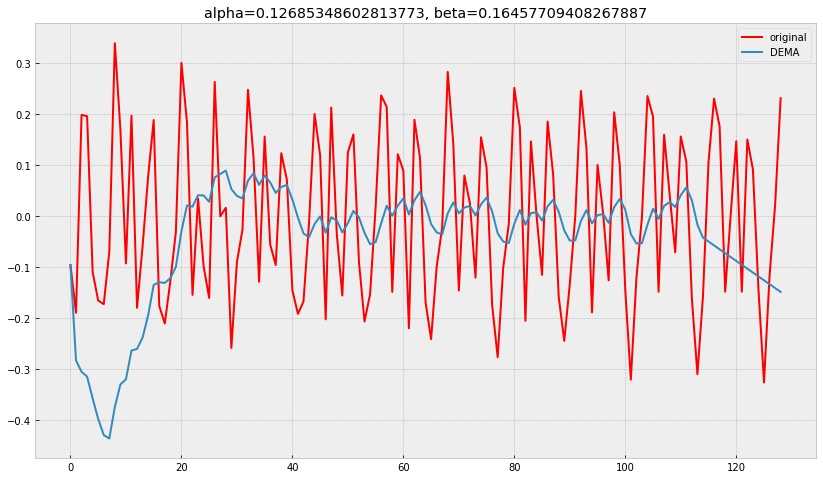

In [161]:
train, val = stat_series[:115], stat_series[115:]
opt_dema = minimize(dema_mse_cross_val, x0=[0.0,0.0], args=train, method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt_dema, beta_opt_dema = opt_dema.x
plot_dema(alpha_opt_dema, beta_opt_dema, stat_series, train, len(val))

Со стационарным также неважно

## Хольт-Винтерс

In [31]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum = sum+ float(series[i+season_len] - series[i]) / float(season_len)
    return sum / season_len

In [32]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [33]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            
            continue
        
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [49]:
def plot_tema(alpha, beta, gamma, ser_orig, ser_preds, n_preds):
    tema = triple_exponential_smoothing(ser_preds, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_orig, color='red',label='original')
        plt.plot(tema, linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

#### Подбираем параметры для рядов

In [50]:
def tema_mse_cross_val(X, train_series):
    train_series = pd.Series(train_series)
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_series):
        train_split_ts = train_series.iloc[train_split]
        test_split_ts = train_series.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

In [36]:
train, val = series[:115], series[115:]

In [51]:
opt_tema = minimize(tema_mse_cross_val, x0=[0,0,0], args=train, method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [52]:
alpha_opt_tema, beta_opt_tema, gamma_opt_tema = opt_tema.x
print(opt_tema)

      fun: 284.8725348830821
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.48014975e-04, -3.06386028e-03, -2.40639679e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 340
      nit: 58
   status: 0
  success: True
        x: array([0.11739348, 0.08225841, 1.        ])


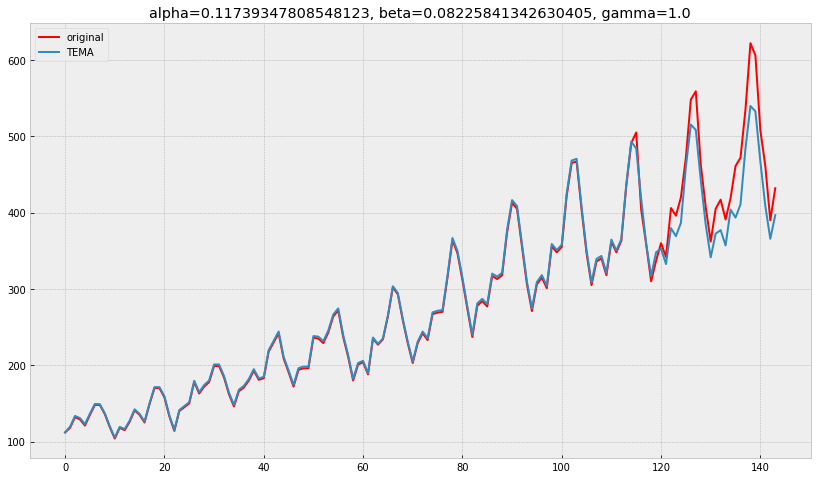

In [53]:
plot_tema(alpha_opt_tema, beta_opt_tema, gamma_opt_tema, series, train, len(val))

Наконец-то получен результат хоть с каким-то устойчивым прогнозом! Видно, что алгоритм прогнозируется как тренд, так и сезонность.

А теперь то же самое для стационарного ряда:

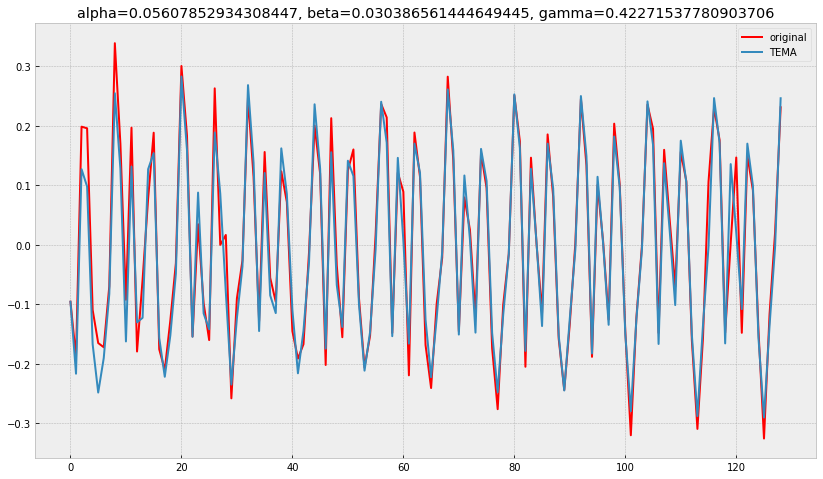

In [54]:
train, val = stat_series[:115], stat_series[115:]
opt_tema = minimize(tema_mse_cross_val, x0=[0,0,0], args=train, method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt_tema, beta_opt_tema, gamma_opt_tema = opt_tema.x
plot_tema(alpha_opt_tema, beta_opt_tema, gamma_opt_tema, stat_series, train, len(val))

Тоже неплохо.

**Вывод:**

Более-менее нечто похожее на прогнозирование дает только алгоритм Хольта-Винтерса, остальные алгоритмы для прогнозирования не годятся, имеют скорее аналитическое назначение.